<a href="https://colab.research.google.com/github/guntsvzz/CP_Project/blob/main/EEG_Stress_LSTM_Chunking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
!gdown --id 1KZjrJfUrB_k1g8VUsohNpek_hvWNqGcr

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KZjrJfUrB_k1g8VUsohNpek_hvWNqGcr
To: /content/Clean_signal.zip
100% 113M/113M [00:00<00:00, 226MB/s] 


In [3]:
!unzip '/content/Clean_signal.zip'
#!mv '/content/clean_exp16' 'Cleaned_signal'

Archive:  /content/Clean_signal.zip
   creating: Clean_signal/
  inflating: __MACOSX/._Clean_signal  
  inflating: Clean_signal/PSS10 - Sheet1.csv  
  inflating: __MACOSX/Clean_signal/._PSS10 - Sheet1.csv  
  inflating: Clean_signal/clean_exp08.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp08.csv  
  inflating: Clean_signal/clean_exp09.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp09.csv  
  inflating: Clean_signal/clean_exp01.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp01.csv  
  inflating: Clean_signal/clean_exp15.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp15.csv  
  inflating: Clean_signal/clean_exp14.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp14.csv  
  inflating: Clean_signal/clean_exp16.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp16.csv  
  inflating: Clean_signal/clean_exp02.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp02.csv  
  inflating: Clean_signal/clean_exp03.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp03.csv  
 

In [4]:
pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 15.6 MB/s 


In [5]:
pip install components

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
import pickle
import numpy as np
import os
import mne
import pandas as pd
pickle.format_version

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms  
from torch.utils.data import DataLoader, Dataset  
from torch.utils.data import TensorDataset
from torch.autograd import Variable

import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# setting seed so that splitting process and training process can be reproduce
torch.manual_seed(1)

# ETL

In [54]:
import os
main_path = os.getcwd()
filename = os.listdir(main_path + '/Clean_signal/')

In [55]:
filename = ['clean_exp01.csv',
 'clean_exp02.csv',
 'clean_exp03.csv',
 'clean_exp04.csv',
 'clean_exp05.csv',
 'clean_exp06.csv',
 'clean_exp07.csv',
 'clean_exp08.csv',
 'clean_exp09.csv',
 'clean_exp10.csv',
 'clean_exp11.csv',
 'clean_exp12.csv',
 'clean_exp13.csv',
 'clean_exp14.csv',
 'clean_exp15.csv',
 'clean_exp16.csv',
 'clean_exp17.csv']

In [56]:
all_file_path = main_path + '/Clean_signal/'
X_list = list()
for file in filename:
    file_path = all_file_path + file
    df = pd.read_csv(file_path, index_col=None)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    X_list.append(df)  

In [57]:
df.head()

,Fp1,Fp2,F7,F3,F4,F8,T3,C3,C4,T4,T5,P3,P4,T6,O1,O2
0,1.558541e-13,1.202787e-12,-1.822815e-12,-6.666149e-13,-1.524659e-14,-9.656176e-14,1.778769e-13,-7.318365e-13,-3.218725e-14,6.776264e-15,2.463172e-12,-5.293956e-13,1.679243e-13,2.774456e-12,-3.303428e-13,2.217109e-13
1,-2.495299e+02,-2.591266e+02,-2.392414e+02,-2.472481e+02,-1.342918e+02,-2.469675e+02,-2.368676e+02,-2.375381e+02,8.964020e+01,9.114929e+01,9.105020e+01,7.684951e+01,1.383037e+02,-4.155527e+02,-3.083336e+02,-1.145710e+02
2,-1.022146e+02,-1.071695e+02,-8.913196e+01,-9.320015e+01,-7.188064e+01,-9.669399e+01,-7.360927e+01,-7.934479e+01,-8.483305e+00,-3.966042e+00,6.921319e-02,-5.860820e+00,6.340924e+00,-1.006591e+02,-7.385641e+01,-3.186257e+01
3,-1.894707e+02,-1.985657e+02,-1.666088e+02,-1.773347e+02,-1.206077e+02,-1.861381e+02,-1.566157e+02,-1.616160e+02,1.053098e+01,1.359837e+01,2.570865e+01,1.375228e+01,4.319836e+01,-2.383818e+02,-1.751361e+02,-7.472951e+01
4,-1.976600e+02,-2.088452e+02,-1.691085e+02,-1.829386e+02,-1.219805e+02,-1.981792e+02,-1.664133e+02,-1.711082e+02,5.430791e+00,5.540176e+00,2.039321e+01,9.522058e+00,4.153111e+01,-2.713544e+02,-1.985949e+02,-9.082392e+01


In [58]:
X = np.array(X_list)
X.shape 
#17 people 
#250 hz * 60 secs * 3 min
#16 channels

(17, 45000, 16)

In [59]:
# Reshape
X = np.transpose(X, (0, 2, 1))
X.shape

(17, 16, 45000)

In [60]:
def vectorized_windowing(arr, window_len, overlap_len=None):
    '''
    Sliding window without using loop
    '''
    seq_len = arr.shape[-1]
    
    if not overlap_len:
        overlap_len = window_len

    n_sliding_windows = ((seq_len - window_len) // overlap_len) + 1

    sub_windows = np.array([np.arange(window_len)]) + np.array([np.arange(n_sliding_windows) * overlap_len]).T

    slided_arr = arr[..., sub_windows]

    return slided_arr


In [61]:
X_chunked = vectorized_windowing(X, window_len=4500)
X_chunked = np.swapaxes(X_chunked,1,2).reshape(-1, 16, 4500)

print(X_chunked.shape)

X = X_chunked.copy()

# 17 people split in 10 chunks
# 16 channels
# 4500 signals 

(170, 16, 4500)


In [62]:
y_path = '/content/Clean_signal/PSS10 - Sheet1.csv'
df = pd.read_csv(y_path)
y = np.array(df['label'])
y

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [63]:
y_chunked = np.repeat(y, 10)

y = y_chunked.copy()

In [64]:
y_chunked.shape

(170,)

# Split Data

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False, stratify = None)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(136, 16, 4500) (34, 16, 4500) (136,) (34,)


In [66]:
print(X_test)

[[[ 7.84200330e+00  1.47207470e+01  1.42052595e+01 ... -5.89349247e+00
   -1.51828042e+01 -2.08104358e+01]
  [ 3.16583543e+00  8.26135009e+00  9.23106733e+00 ... -2.71454574e+01
   -3.25662288e+01 -3.54135998e+01]
  [ 2.32398500e+00  5.09731303e+00  3.61993697e-01 ... -1.74988647e+01
   -2.87856476e+01 -3.47425425e+01]
  ...
  [-8.76076464e+00 -1.74142656e+00  5.77302593e-01 ...  2.39540520e+00
    2.14318766e+00 -1.96665306e+00]
  [ 3.02666012e+00  6.51500100e+00  4.10581095e+00 ...  3.91447209e+01
    3.74479023e+01  2.25009333e+01]
  [-1.46662092e+01 -3.50361569e+00  1.18964341e+00 ...  1.17311595e+01
    1.10058886e+01 -3.73502614e+00]]

 [[-1.82454441e+01 -1.57154517e+01 -9.08109711e+00 ... -5.01454830e+00
   -8.80962712e+00 -4.94259629e+00]
  [-3.47973429e+01 -3.61339346e+01 -2.94382432e+01 ... -2.55171581e+00
   -7.39142312e+00 -5.25420300e+00]
  [-3.00576255e+01 -3.15323330e+01 -2.53430851e+01 ...  2.28278037e+00
   -2.40692220e+00 -6.11756015e-02]
  ...
  [-2.07971800e+00 -2.5

In [67]:
print(X_test)

[[[ 7.84200330e+00  1.47207470e+01  1.42052595e+01 ... -5.89349247e+00
   -1.51828042e+01 -2.08104358e+01]
  [ 3.16583543e+00  8.26135009e+00  9.23106733e+00 ... -2.71454574e+01
   -3.25662288e+01 -3.54135998e+01]
  [ 2.32398500e+00  5.09731303e+00  3.61993697e-01 ... -1.74988647e+01
   -2.87856476e+01 -3.47425425e+01]
  ...
  [-8.76076464e+00 -1.74142656e+00  5.77302593e-01 ...  2.39540520e+00
    2.14318766e+00 -1.96665306e+00]
  [ 3.02666012e+00  6.51500100e+00  4.10581095e+00 ...  3.91447209e+01
    3.74479023e+01  2.25009333e+01]
  [-1.46662092e+01 -3.50361569e+00  1.18964341e+00 ...  1.17311595e+01
    1.10058886e+01 -3.73502614e+00]]

 [[-1.82454441e+01 -1.57154517e+01 -9.08109711e+00 ... -5.01454830e+00
   -8.80962712e+00 -4.94259629e+00]
  [-3.47973429e+01 -3.61339346e+01 -2.94382432e+01 ... -2.55171581e+00
   -7.39142312e+00 -5.25420300e+00]
  [-3.00576255e+01 -3.15323330e+01 -2.53430851e+01 ...  2.28278037e+00
   -2.40692220e+00 -6.11756015e-02]
  ...
  [-2.07971800e+00 -2.5

In [68]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=999)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(122, 16, 4500) (14, 16, 4500) (122,) (14,)


In [69]:
from sklearn.preprocessing import MinMaxScaler

#scale transform each channel independently
scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i]) 

for i in range(X_val.shape[2]):
    X_val[:, :, i]   = scalers[i].transform(X_val[:, :, i])     
    
for i in range(X_test.shape[2]):
    X_test[:, :, i]  = scalers[i].transform(X_test[:, :, i]) 

In [70]:
print(X_train.mean(), X_val.mean(), X_test.mean())
print(X_train.min(), X_val.min(), X_test.min())
print(X_train.max(), X_val.max(), X_test.max())

0.004228958769664231 0.004157039756496878 0.004641125739653987
-1.0 -29.253222821649473 -257.7915643965592
1.0000000000000004 15.788878605040534 870.0946728954643


### Fix imblanced

In [71]:
labels_unique, counts = np.unique(y, return_counts=True)
labels_unique, counts

(array([0, 1]), array([100,  70]))

In [72]:
class_weights = [sum(counts) / c for c in counts]
class_weights

[1.7, 2.4285714285714284]

In [73]:
sample_weights_train = [class_weights[i] for i in y_train]
sample_weights_val   = [class_weights[i] for i in y_val  ]
sample_weights_test  = [class_weights[i] for i in y_test ]

In [74]:
from torch.utils.data import WeightedRandomSampler


train_sampler = WeightedRandomSampler(sample_weights_train, len(y_train), replacement=True)
val_sampler   = WeightedRandomSampler(sample_weights_val,   len(y_val),   replacement=True)
test_sampler  = WeightedRandomSampler(sample_weights_test,  len(y_test),  replacement=True)

# Define Batch size and train,test, val loader

In [75]:
X_train_tensor = torch.tensor(X_train).to(torch.float32)
y_train_tensor = torch.tensor(y_train).to(torch.float32)
X_val_tensor = torch.tensor(X_val).to(torch.float32)
y_val_tensor = torch.tensor(y_val).to(torch.float32)
X_test_tensor = torch.tensor(X_test).to(torch.float32)
y_test_tensor = torch.tensor(y_test).to(torch.float32)

# Cast data to dataloader for more convenience
training_set = TensorDataset(X_train_tensor, y_train_tensor)
testing_set = TensorDataset(X_test_tensor, y_test_tensor)
validation_set = TensorDataset(X_val_tensor, y_val_tensor)

train_batch_size = 32
val_batch_size = len(validation_set)
test_batch_size = len(testing_set)

train_loader = DataLoader(training_set, train_batch_size, sampler=train_sampler)
val_loader = DataLoader(validation_set, val_batch_size, sampler=val_sampler)
test_loader = DataLoader(testing_set, test_batch_size, shuffle=test_sampler)

In [76]:
for data, label in train_loader:
  print(data)
  break

tensor([[[ 0.1409, -0.4435, -0.1265,  ...,  0.4204,  0.1690,  0.3592],
         [ 0.1778,  0.8264,  0.4899,  ...,  0.8109,  0.8987,  0.5645],
         [ 0.1739, -0.2776,  0.0607,  ..., -0.1719, -0.0526,  0.1300],
         ...,
         [ 0.4724, -0.6238,  0.0778,  ...,  0.7720,  0.1902,  0.6705],
         [ 0.7702,  0.7492,  0.7593,  ...,  0.7007,  0.7295,  0.7588],
         [ 0.7474,  0.6732,  0.0612,  ...,  0.9397,  0.8497,  0.7683]],

        [[ 0.3832, -0.3869, -0.1121,  ..., -0.0028, -0.1952,  0.1631],
         [ 0.2516,  0.7962,  0.3502,  ...,  0.6884,  0.8623,  0.4361],
         [ 0.2530, -0.4469, -0.0766,  ..., -0.4627, -0.3772, -0.0748],
         ...,
         [ 0.4773, -0.6589, -0.1112,  ...,  0.7757,  0.1949,  0.6766],
         [ 0.7759,  0.7479,  0.7524,  ...,  0.7061,  0.7362,  0.7674],
         [ 0.7562,  0.6473, -0.0124,  ...,  0.9480,  0.8582,  0.7777]],

        [[ 0.4009, -0.4025, -0.1494,  ..., -0.0950, -0.7196,  0.1631],
         [ 0.3356,  0.8194,  0.4492,  ...,  0

In [77]:
data.shape

torch.Size([32, 16, 4500])

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# LSTM model

In [79]:
class LSTM(nn.Module):
    '''
    Expected Input Shape: (batch, channels, seq_len, )
    '''
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_layers, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, channels, seq len, ]
        out, (hn, cn) = self.lstm(x)
        
        #out = [batch size, seq len, hidden dim * num directions]        
        #hn = [num layers * num directions, batch size, hidden dim]
        #cn = [num layers * num directions, batch size, hidden dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

In [80]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):   #if layer is of Linear
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):   #if layer is of LSTM
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)  #orthogonal is a common way to initialize weights for RNN/LSTM/GRU

In [81]:
input_size     = 16 #channel 
hidden_size    = 100
num_layers    = 2
output_size    = 1  #we got 2 classes so we can output only 1 number, 0 for first class and 1 for another class
bidirectional = True  #uses bidirectional LSTM
dropout       = 0.5

#define the model
model = LSTM(input_size, hidden_size, num_layers, output_size, bidirectional, dropout)

#send to cuda so we can use the GPU
model = model.to(device)  

#apply weights
model.apply(initialize_weights)

LSTM(
  (lstm): LSTM(16, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

In [82]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model


The model LSTM has 336,201 trainable parameters


In [83]:
for testx, testy in train_loader:
    print(testx.shape, testy.shape)
    break

torch.Size([32, 16, 4500]) torch.Size([32])


In [95]:
torch.manual_seed(42)
torch.manual_seed(17)
torch.manual_seed(999)
torch.manual_seed(200)
torch.manual_seed(99)
model_save_path = '/models/LSTM_Chunking_Cleaned.pt'

In [96]:
list_seed = [42, 17, 999, 200, 99]

In [86]:
import torch.optim as optim

num_epochs = 100

lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=lr) 
criterion = nn.BCEWithLogitsLoss() 

In [87]:
#for measuring accuracy
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc


In [88]:
torch.sigmoid(torch.tensor([[-1.1193],
        [-1.7878]]) )

tensor([[0.2461],
        [0.1433]])

In [89]:
#for timing the epochs
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [90]:
def train(model, train_loader,  optimizer, criterion):

    model.train()
    epoch_train_loss = 0
    epoch_train_acc  = 0

    for i, batch in enumerate(train_loader):
        # print(batch[0].shape)
        # data shape: (batch, channel, seq len)
        data  = batch[0].to(device).permute(0, 2, 1)    
        # data shape: (batch, seq len, channel)

        # label shape: (batch, 1)
        label = batch[1].to(device).reshape(-1, 1)
        
        #predict
        output = model(data).reshape(-1, 1)  #output shape: (batch, 1)
        loss   = criterion(output, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #for visualizing
        epoch_train_loss += loss.item()
        acc = binary_accuracy(output, label)
        epoch_train_acc += acc.item()
        
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_acc  = epoch_train_acc  / len(train_loader)
    
    return epoch_train_loss, epoch_train_acc


In [91]:
def evaluate(model, val_loader, criterion):

    model.eval()
    epoch_val_loss = 0
    epoch_val_acc  = 0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            
            # data shape: (batch, channel, seq len)
            data  = batch[0].to(device).permute(0, 2, 1)   
            label = batch[1].to(device).reshape(-1, 1)
            
            #predict
            output = model(data).reshape(-1, 1)
            loss   = criterion(output, label)
            
            #for visualizing
            epoch_val_loss += loss.item()
            acc = binary_accuracy(output, label)
            epoch_val_acc += acc.item()
    
    epoch_val_loss =  epoch_val_loss / len(val_loader)
    epoch_val_acc  =  epoch_val_acc  / len(val_loader)
    
    return epoch_val_loss, epoch_val_acc


In [92]:
import time

In [93]:
list_seed = [42, 17, 999, 200, 99]

In [94]:
for seed in list_seed:
    torch.manual_seed(seed)
    model_name = str(seed) + '_LSTM_Chunking_Cleaned.pt'
    model_save_path = '/content/models/' + model_name

    for layer in model.children():
      if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()

    train_losses = []
    train_accs   = []
    valid_losses = []
    valid_accs   = []

    for epoch in range(num_epochs):
        
        start_time = time.time()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        #print('EVAL')
        valid_loss, valid_acc = evaluate(model, val_loader, criterion)
        
        #for plotting
        train_losses.append(train_loss)
        train_accs  .append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs  .append(valid_acc)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_acc = train_acc
            best_loss = train_loss
            best_val_acc = valid_acc
            best_val_loss = valid_loss
            torch.save(model.state_dict(), model_save_path)
            
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Seed: {seed}')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {best_loss:.3f} | Train Acc: {best_acc*100:.2f}%')
    print(f'\t Val. Loss: {best_val_loss:.3f}  |  Val. Acc: {best_val_acc*100:.2f}%')

Seed: 42
Epoch: 100 | Epoch Time: 0m 1s
	 Train Loss: 0.398 | Train Acc: 81.31%
	 Val. Loss: 0.506  |  Val. Acc: 64.29%
Seed: 17
Epoch: 100 | Epoch Time: 0m 1s
	 Train Loss: 0.522 | Train Acc: 68.27%
	 Val. Loss: 0.414  |  Val. Acc: 71.43%
Seed: 999
Epoch: 100 | Epoch Time: 0m 1s
	 Train Loss: 0.522 | Train Acc: 68.27%
	 Val. Loss: 0.414  |  Val. Acc: 71.43%
Seed: 200
Epoch: 100 | Epoch Time: 0m 1s
	 Train Loss: 0.522 | Train Acc: 68.27%
	 Val. Loss: 0.414  |  Val. Acc: 71.43%
Seed: 99
Epoch: 100 | Epoch Time: 0m 1s
	 Train Loss: 0.522 | Train Acc: 68.27%
	 Val. Loss: 0.414  |  Val. Acc: 71.43%


In [ ]:
def test(model, val_loader, criterion):

    model.eval()
    epoch_val_loss = 0
    epoch_val_acc  = 0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            
            # data shape: (batch, channel, seq len)
            data  = batch[0].to(device).permute(0, 2, 1)   
            label = batch[1].to(device).reshape(-1, 1)
            
            #predict
            output = model(data).reshape(-1, 1)
            loss   = criterion(output, label)
            
            #for visualizing
            epoch_val_loss += loss.item()
            acc = binary_accuracy(output, label)
            epoch_val_acc += acc.item()
    
    epoch_val_loss =  epoch_val_loss / len(val_loader)
    epoch_val_acc  =  epoch_val_acc  / len(val_loader)
    
    return epoch_val_loss, epoch_val_acc

In [ ]:
input_size     = 16 #channel 
hidden_size    = 100
num_layers    = 2
output_size    = 1  #we got 2 classes so we can output only 1 number, 0 for first class and 1 for another class
bidirectional = True  #uses bidirectional LSTM
dropout       = 0.5

optimizer = optim.Adam(model.parameters(), lr=lr) 
criterion = nn.BCEWithLogitsLoss() 

In [103]:
for i, batch in enumerate(test_loader):
    # print(batch[0].shape)
    # data shape: (batch, channel, seq len)
    data  = batch[0].to(device).permute(0, 2, 1)
    print(data)
    break
    

tensor([[[ 0.3097,  0.2671,  0.2175,  ...,  0.4516,  0.7701,  0.8577],
         [-0.4833,  0.8045, -0.4045,  ..., -0.6577,  0.7430,  0.8170],
         [-0.1152,  0.4495, -0.0287,  ..., -0.0700,  0.7483,  0.2747],
         ...,
         [ 0.3264,  0.7735, -0.1568,  ...,  0.7732,  0.7093,  0.9524],
         [ 0.1617,  0.9096,  0.0510,  ...,  0.2135,  0.7454,  0.8630],
         [ 0.3886,  0.6813,  0.3734,  ...,  0.7632,  0.7790,  0.7864]],

        [[ 0.3956,  0.3560,  0.0863,  ...,  0.4851,  0.7724,  0.7408],
         [-0.5162,  0.7958, -0.7149,  ..., -0.6732,  0.7442,  0.6155],
         [-0.2486,  0.3320, -0.3096,  ..., -0.2125,  0.7408, -0.1020],
         ...,
         [ 0.5186,  0.8792, -0.6828,  ...,  0.8279,  0.7155,  1.0537],
         [ 1.3872,  1.0246, -2.0094,  ...,  0.2995,  0.7611,  1.3346],
         [ 0.1631,  0.4361, -0.0748,  ...,  0.6766,  0.7674,  0.7777]],

        [[ 0.2976,  0.2480,  0.1970,  ...,  0.4852,  0.7734,  0.7507],
         [ 0.7806,  0.9944,  0.9111,  ..., -0

In [106]:
# Testing using Seed 200 as it seem to be the best
s17_path = '/content/models/17_LSTM_Chunking_Cleaned.pt'

model = model = LSTM(input_size, hidden_size, num_layers, output_size, bidirectional, dropout).to(device)
model.load_state_dict(torch.load(s17_path))
model.eval()

test_loss, test_acc = evaluate(model, test_loader, criterion)
test_acc = test_acc * 100
#_, predicted = torch.max(result.data, 1)

#yhat = predicted.detach().cpu().numpy()

#accuracy_score(y_test, yhat) * 100
print(f'Test Accuracy: {test_acc}, Test Loss: {test_loss}')

Test Accuracy: 52.941179275512695, Test Loss: 0.8423960208892822


Text(0, 0.5, 'loss')

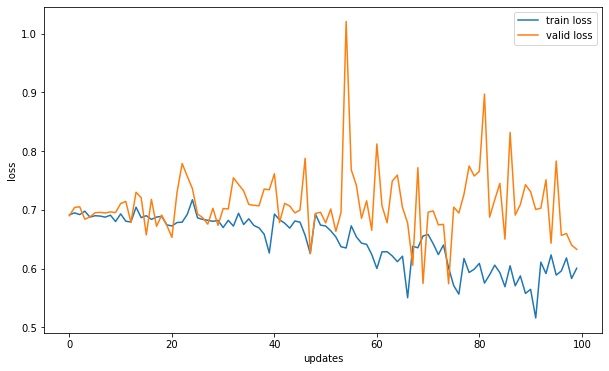

In [108]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

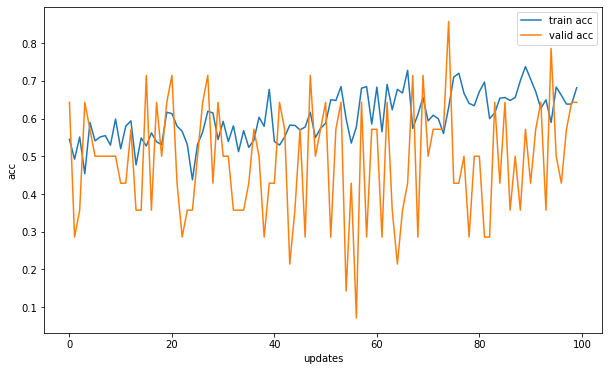

In [109]:
fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')